[nltk_data] Downloading package stopwords to C:\Users\may/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


n_estimators=10, Accuracy=0.9373
n_estimators=60, Accuracy=0.9751
n_estimators=110, Accuracy=0.9797
n_estimators=160, Accuracy=0.9827
n_estimators=210, Accuracy=0.9839
n_estimators=260, Accuracy=0.9844
n_estimators=310, Accuracy=0.9851
n_estimators=360, Accuracy=0.9855
n_estimators=410, Accuracy=0.9861
n_estimators=460, Accuracy=0.9866
n_estimators=510, Accuracy=0.9867
n_estimators=560, Accuracy=0.9870
n_estimators=610, Accuracy=0.9870
n_estimators=660, Accuracy=0.9870
n_estimators=710, Accuracy=0.9869
n_estimators=760, Accuracy=0.9869
n_estimators=810, Accuracy=0.9867
n_estimators=860, Accuracy=0.9871
n_estimators=910, Accuracy=0.9871
n_estimators=960, Accuracy=0.9874


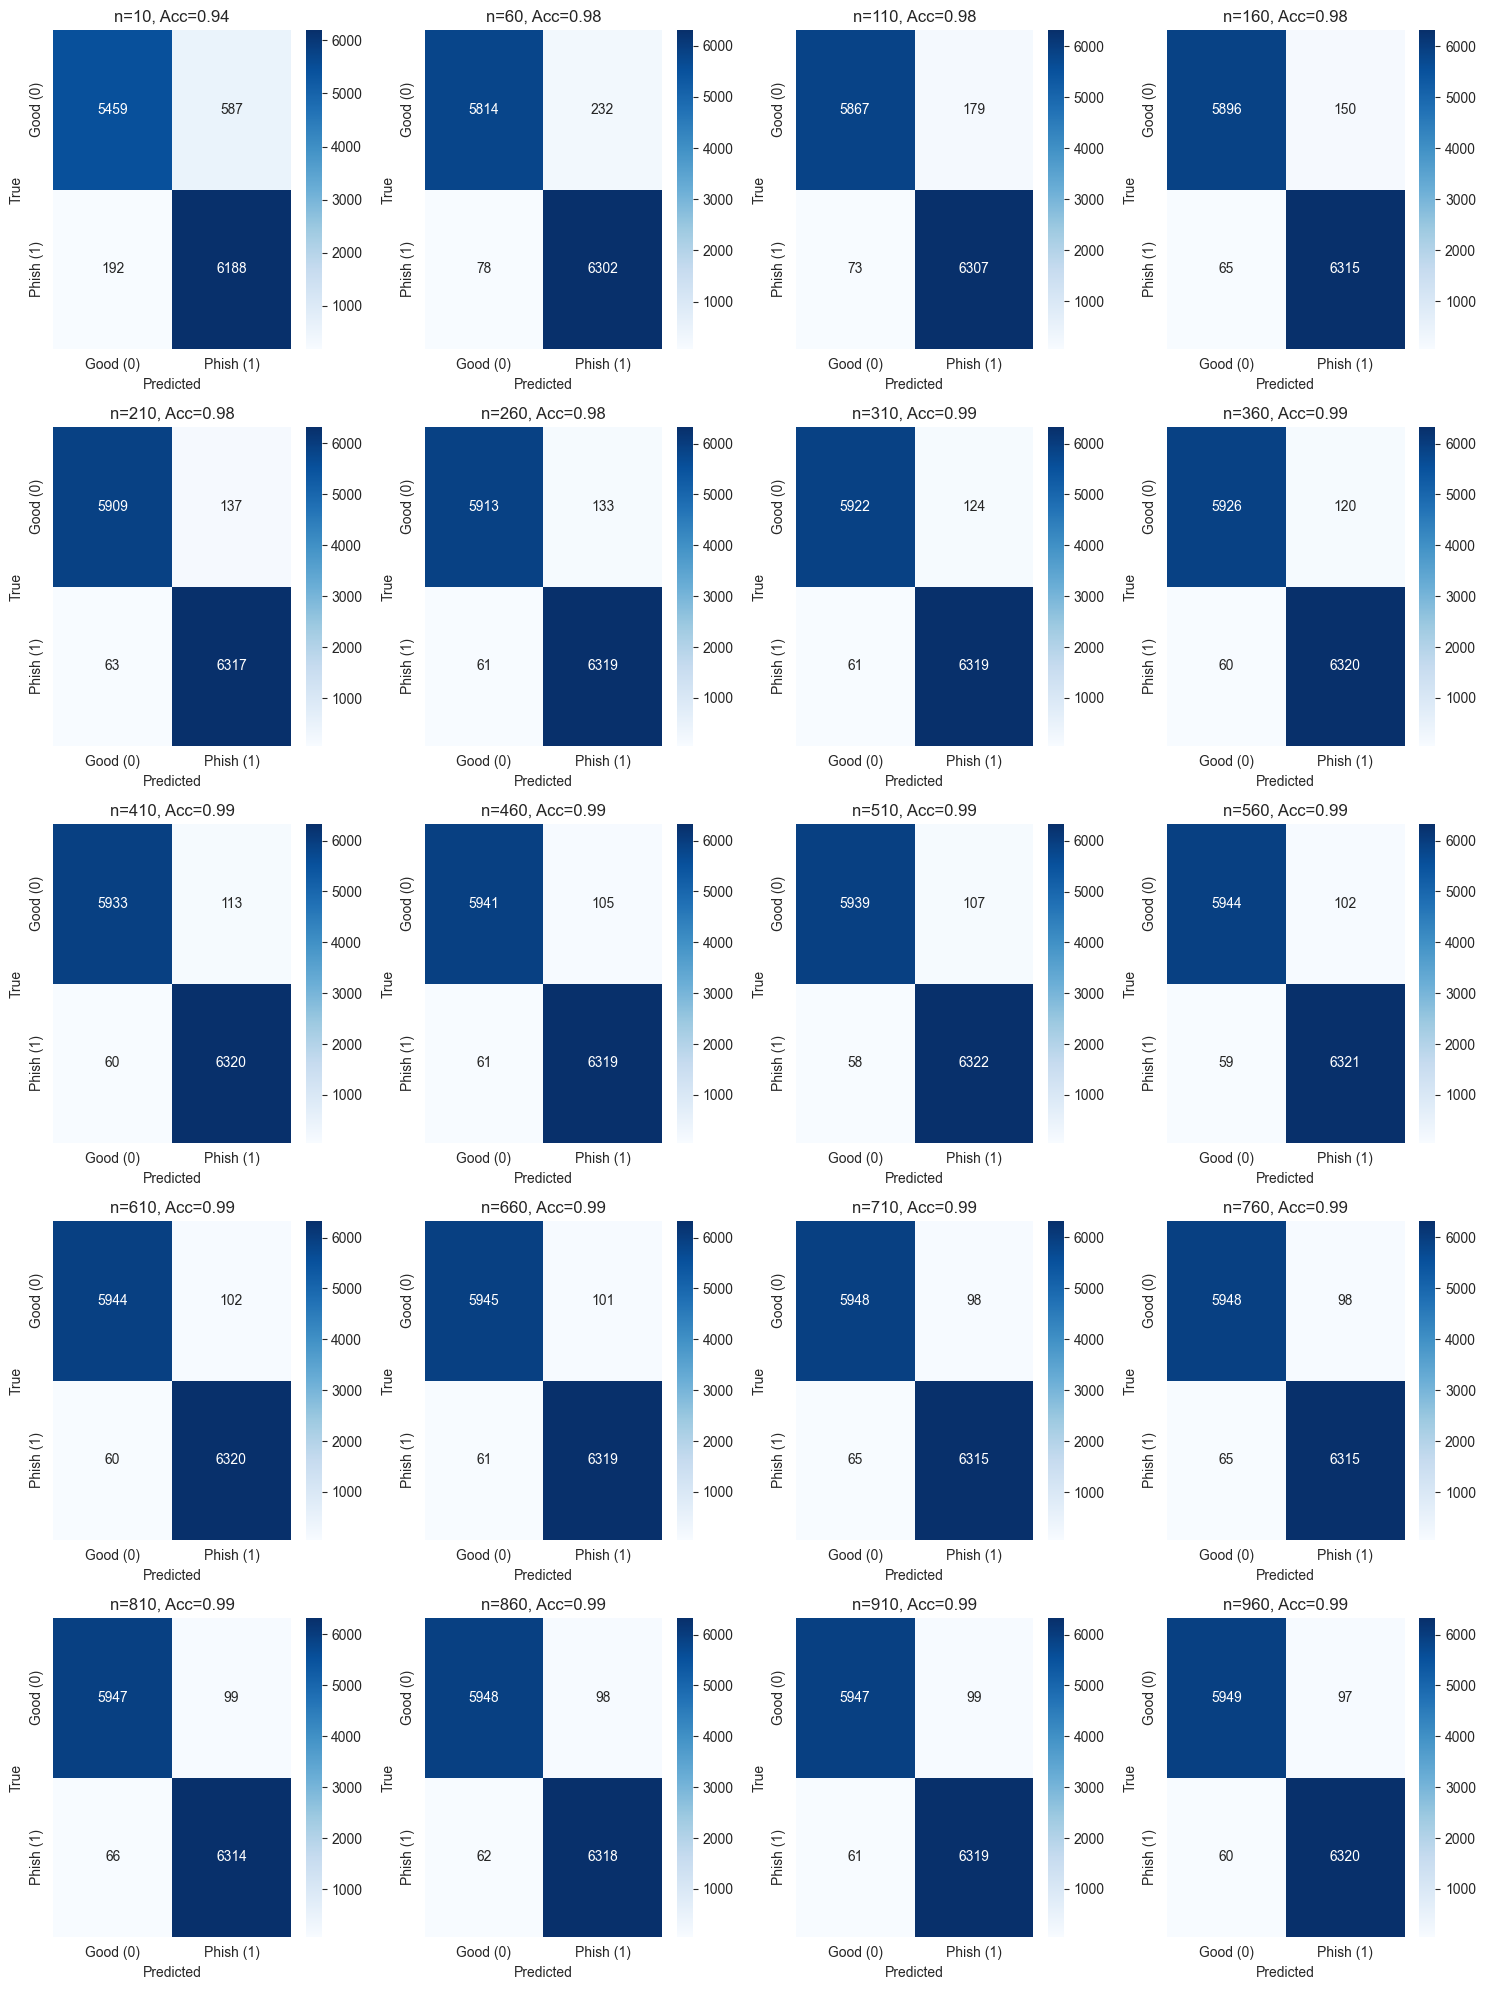

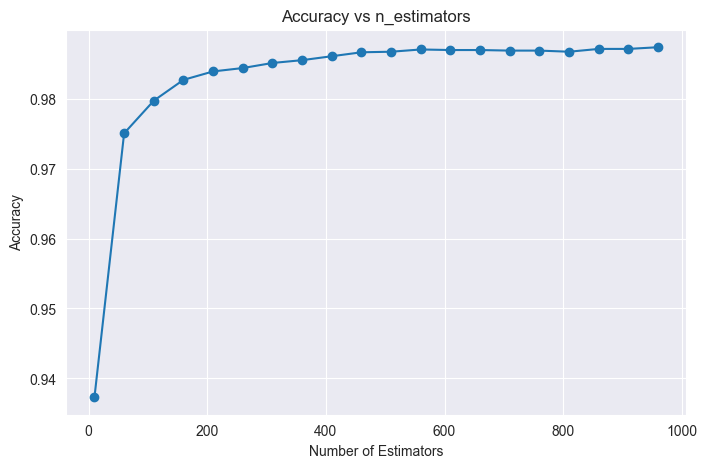

In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from xgboost import XGBClassifier
from joblib import Parallel, delayed

# Load dataset
df_1 = pd.read_csv(r"C:\Users\may\Desktop\dataset\CEAS_08.csv")
df_2 = pd.read_csv(r"C:\Users\may\Desktop\dataset\data.csv")
df_3 = pd.read_csv(r"C:\Users\may\Desktop\dataset\balanced.csv")

# Extract relevant features and target
df_1 = df_1[['sender', 'subject', 'body', 'label']]
df_2 = df_2.rename(columns={'Email Text': 'body', 'Email Type': 'label'})
df_3 = df_3.rename(columns={'class': 'label'})

# Convert Email Type to boolean
df_2['label'] = df_2['label'].map({'Safe Email': 0, 'Phishing Email': 1})

# Remove empty values
df_1 = df_1.dropna(subset=['body', 'subject', 'label'])
df_2 = df_2.dropna(subset=['body'])
df_3 = df_3.dropna(subset=['body', 'label'])

# Add missing columns
df_2['sender'] = ''
df_2['subject'] = ''
df_3['sender'] = ''
df_3['subject'] = ''

# Combine datasets
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
df = df[df['label'].isin([0, 1])]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text Cleaning Function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply text cleaning
df['cleaned_sender'] = df['sender'].apply(clean_text)
df['cleaned_subject'] = df['subject'].apply(clean_text)
df['cleaned_body'] = df['body'].apply(clean_text)

# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Define range for n_estimators (10 to 1000, step size 50)
n_estimators_list = range(10, 1001, 50)

# Function to train a model and return results
def train_model(n, X_train, X_test, y_train, y_test):
    xgb_model = XGBClassifier(n_estimators=n, use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    return n, accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred)

# Run training in parallel
results = Parallel(n_jobs=-1)(delayed(train_model)(n, X_train, X_test, y_train, y_test)
                              for n in n_estimators_list)

# Unpack results into dictionaries
accuracies = {n: acc for n, acc, _ in results}
confusion_matrices = {n: cm for n, _, cm in results}

# Print accuracies
for n in n_estimators_list:
    print(f"n_estimators={n}, Accuracy={accuracies[n]:.4f}")

# Plot Confusion Matrices
n_plots = len(n_estimators_list)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for idx, (n, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Good (0)', 'Phish (1)'],
                yticklabels=['Good (0)', 'Phish (1)'],
                ax=axes[idx])
    axes[idx].set_title(f"n={n}, Acc={accuracies[n]:.2f}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("True")

# Hide unused subplots
for i in range(n_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Plot accuracy vs n_estimators
plt.figure(figsize=(8, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o')
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs n_estimators")
plt.grid(True)
plt.show()

[nltk_data] Downloading package stopwords to C:\Users\may/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


n_estimators=1000, Accuracy=0.9873
n_estimators=1100, Accuracy=0.9868
n_estimators=1200, Accuracy=0.9872
n_estimators=1300, Accuracy=0.9870
n_estimators=1400, Accuracy=0.9873
n_estimators=1500, Accuracy=0.9868
n_estimators=1600, Accuracy=0.9867
n_estimators=1700, Accuracy=0.9869
n_estimators=1800, Accuracy=0.9868
n_estimators=1900, Accuracy=0.9870


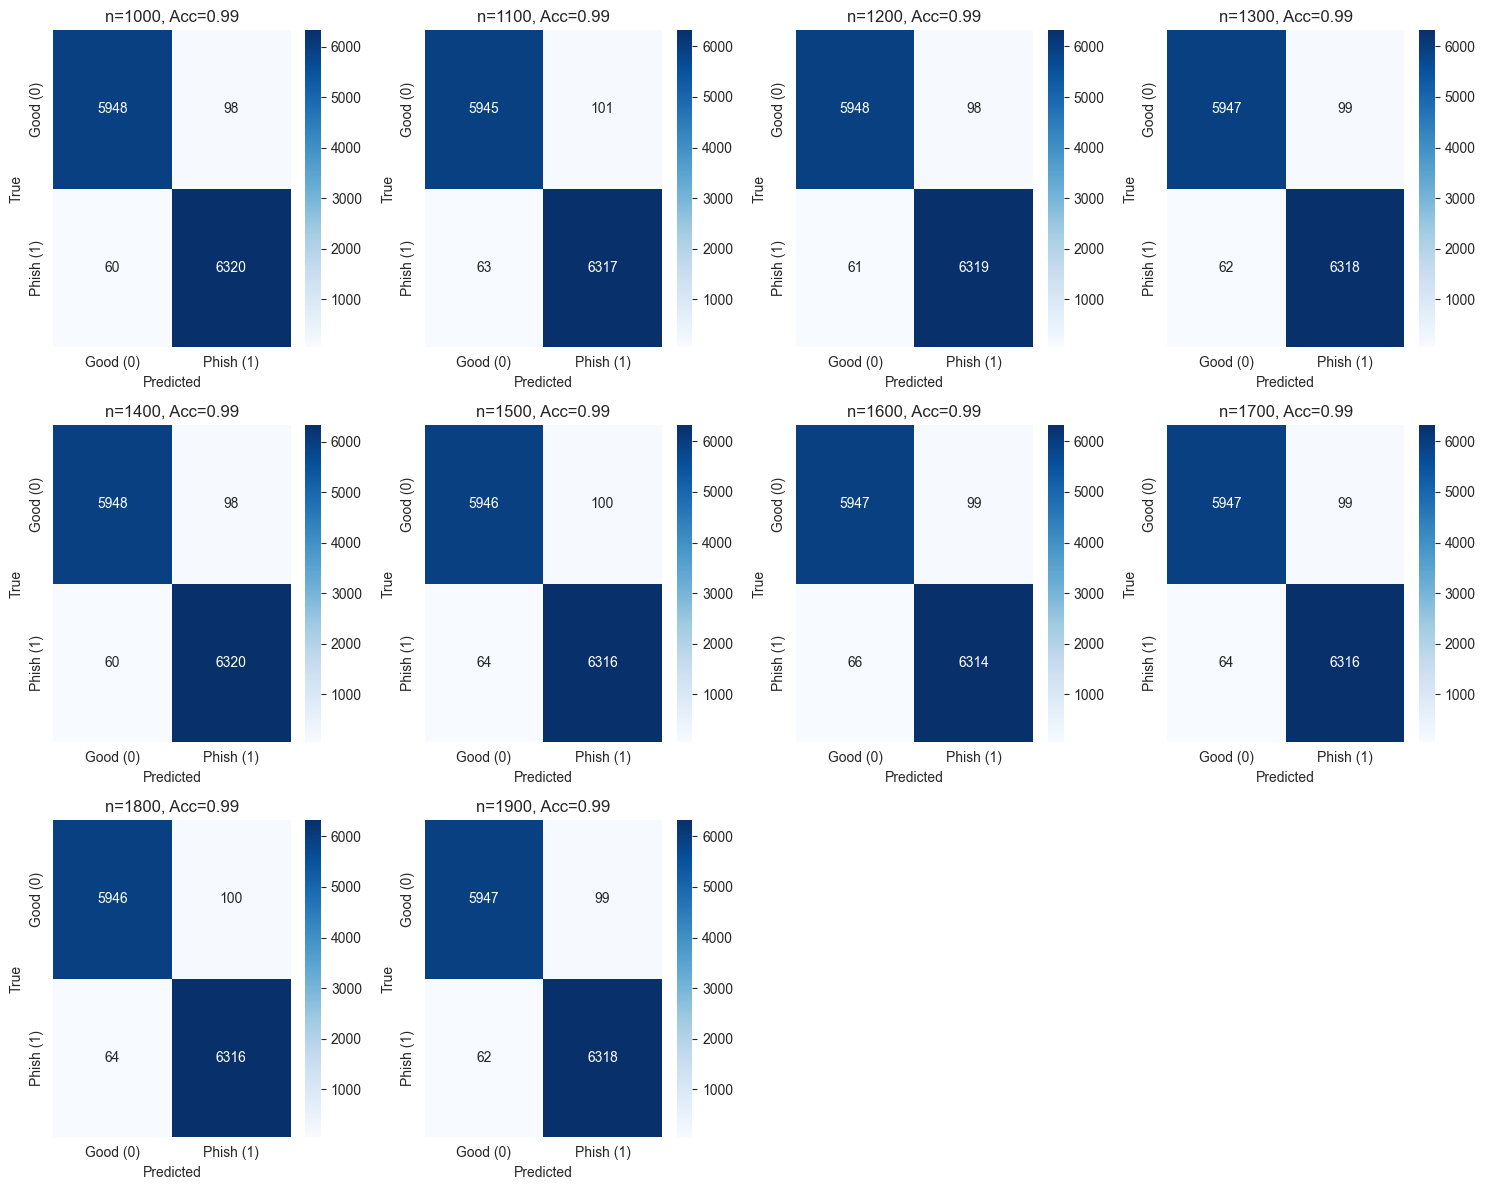

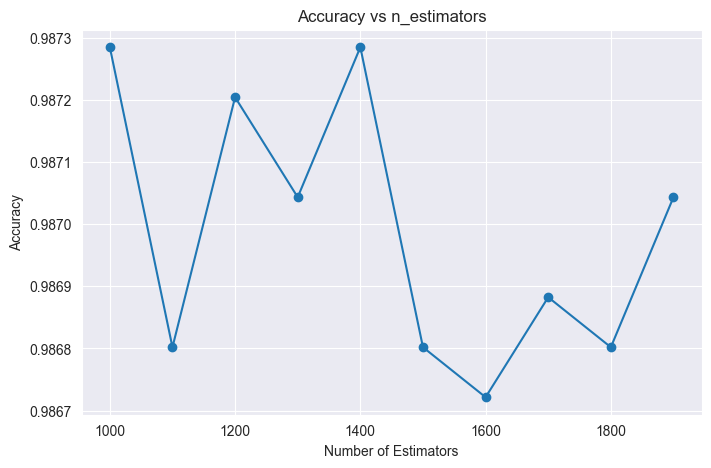

In [4]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from xgboost import XGBClassifier
from joblib import Parallel, delayed

# Load dataset
df_1 = pd.read_csv(r"C:\Users\may\Desktop\dataset\CEAS_08.csv")
df_2 = pd.read_csv(r"C:\Users\may\Desktop\dataset\data.csv")
df_3 = pd.read_csv(r"C:\Users\may\Desktop\dataset\balanced.csv")

# Extract relevant features and target
df_1 = df_1[['sender', 'subject', 'body', 'label']]
df_2 = df_2.rename(columns={'Email Text': 'body', 'Email Type': 'label'})
df_3 = df_3.rename(columns={'class': 'label'})

# Convert Email Type to boolean
df_2['label'] = df_2['label'].map({'Safe Email': 0, 'Phishing Email': 1})

# Remove empty values
df_1 = df_1.dropna(subset=['body', 'subject', 'label'])
df_2 = df_2.dropna(subset=['body'])
df_3 = df_3.dropna(subset=['body', 'label'])

# Add missing columns
df_2['sender'] = ''
df_2['subject'] = ''
df_3['sender'] = ''
df_3['subject'] = ''

# Combine datasets
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
df = df[df['label'].isin([0, 1])]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text Cleaning Function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply text cleaning
df['cleaned_sender'] = df['sender'].apply(clean_text)
df['cleaned_subject'] = df['subject'].apply(clean_text)
df['cleaned_body'] = df['body'].apply(clean_text)

# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Define range for n_estimators (10 to 1000, step size 50)
n_estimators_list = range(1000, 2000, 100)

# Function to train a model and return results
def train_model(n, X_train, X_test, y_train, y_test):
    xgb_model = XGBClassifier(n_estimators=n, use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    return n, accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred)

# Run training in parallel
results = Parallel(n_jobs=-1)(delayed(train_model)(n, X_train, X_test, y_train, y_test)
                              for n in n_estimators_list)

# Unpack results into dictionaries
accuracies = {n: acc for n, acc, _ in results}
confusion_matrices = {n: cm for n, _, cm in results}

# Print accuracies
for n in n_estimators_list:
    print(f"n_estimators={n}, Accuracy={accuracies[n]:.4f}")

# Plot Confusion Matrices
n_plots = len(n_estimators_list)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for idx, (n, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Good (0)', 'Phish (1)'],
                yticklabels=['Good (0)', 'Phish (1)'],
                ax=axes[idx])
    axes[idx].set_title(f"n={n}, Acc={accuracies[n]:.2f}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("True")

# Hide unused subplots
for i in range(n_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Plot accuracy vs n_estimators
plt.figure(figsize=(8, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o')
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs n_estimators")
plt.grid(True)
plt.show()

[nltk_data] Downloading package stopwords to C:\Users\may/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


n_estimators=900, Accuracy=0.9872
n_estimators=950, Accuracy=0.9873
n_estimators=1000, Accuracy=0.9873
n_estimators=1050, Accuracy=0.9871


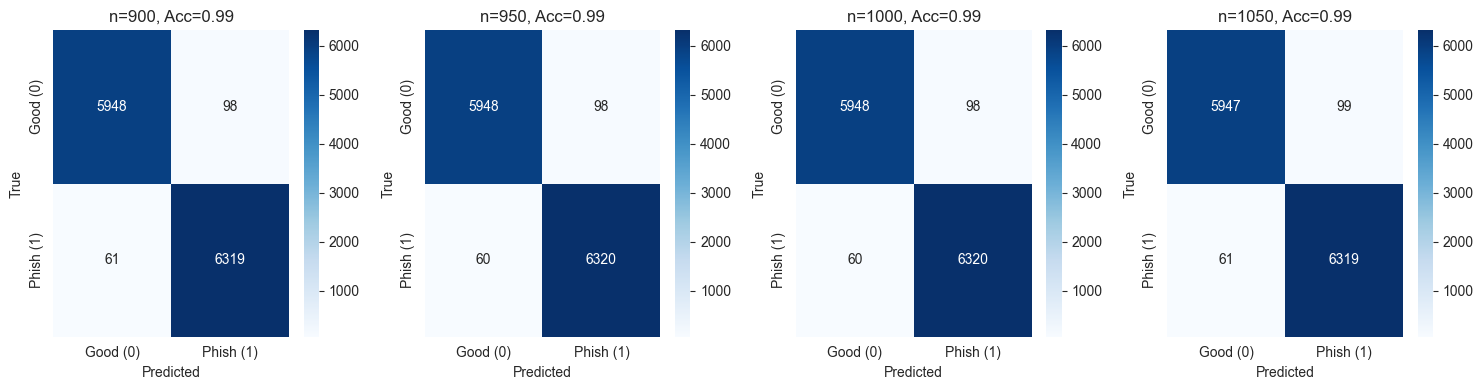

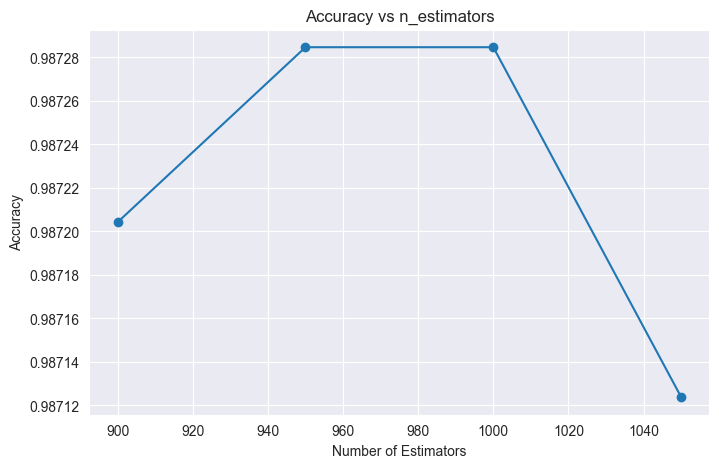

In [7]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from xgboost import XGBClassifier
from joblib import Parallel, delayed

# Load dataset
df_1 = pd.read_csv(r"C:\Users\may\Desktop\dataset\CEAS_08.csv")
df_2 = pd.read_csv(r"C:\Users\may\Desktop\dataset\data.csv")
df_3 = pd.read_csv(r"C:\Users\may\Desktop\dataset\balanced.csv")

# Extract relevant features and target
df_1 = df_1[['sender', 'subject', 'body', 'label']]
df_2 = df_2.rename(columns={'Email Text': 'body', 'Email Type': 'label'})
df_3 = df_3.rename(columns={'class': 'label'})

# Convert Email Type to boolean
df_2['label'] = df_2['label'].map({'Safe Email': 0, 'Phishing Email': 1})

# Remove empty values
df_1 = df_1.dropna(subset=['body', 'subject', 'label'])
df_2 = df_2.dropna(subset=['body'])
df_3 = df_3.dropna(subset=['body', 'label'])

# Add missing columns
df_2['sender'] = ''
df_2['subject'] = ''
df_3['sender'] = ''
df_3['subject'] = ''

# Combine datasets
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
df = df[df['label'].isin([0, 1])]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text Cleaning Function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply text cleaning
df['cleaned_sender'] = df['sender'].apply(clean_text)
df['cleaned_subject'] = df['subject'].apply(clean_text)
df['cleaned_body'] = df['body'].apply(clean_text)

# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Define range for n_estimators (10 to 1000, step size 50)
n_estimators_list = range(900, 1100, 50)

# Function to train a model and return results
def train_model(n, X_train, X_test, y_train, y_test):
    xgb_model = XGBClassifier(n_estimators=n, use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    return n, accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred)

# Run training in parallel
results = Parallel(n_jobs=-1)(delayed(train_model)(n, X_train, X_test, y_train, y_test)
                              for n in n_estimators_list)

# Unpack results into dictionaries
accuracies = {n: acc for n, acc, _ in results}
confusion_matrices = {n: cm for n, _, cm in results}

# Print accuracies
for n in n_estimators_list:
    print(f"n_estimators={n}, Accuracy={accuracies[n]:.4f}")

# Plot Confusion Matrices
n_plots = len(n_estimators_list)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for idx, (n, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Good (0)', 'Phish (1)'],
                yticklabels=['Good (0)', 'Phish (1)'],
                ax=axes[idx])
    axes[idx].set_title(f"n={n}, Acc={accuracies[n]:.2f}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("True")

# Hide unused subplots
for i in range(n_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Plot accuracy vs n_estimators
plt.figure(figsize=(8, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o')
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs n_estimators")
plt.grid(True)
plt.show()

[nltk_data] Downloading package stopwords to C:\Users\may/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


n_estimators=950, Accuracy=0.9873
n_estimators=960, Accuracy=0.9874
n_estimators=970, Accuracy=0.9874
n_estimators=980, Accuracy=0.9875
n_estimators=990, Accuracy=0.9874


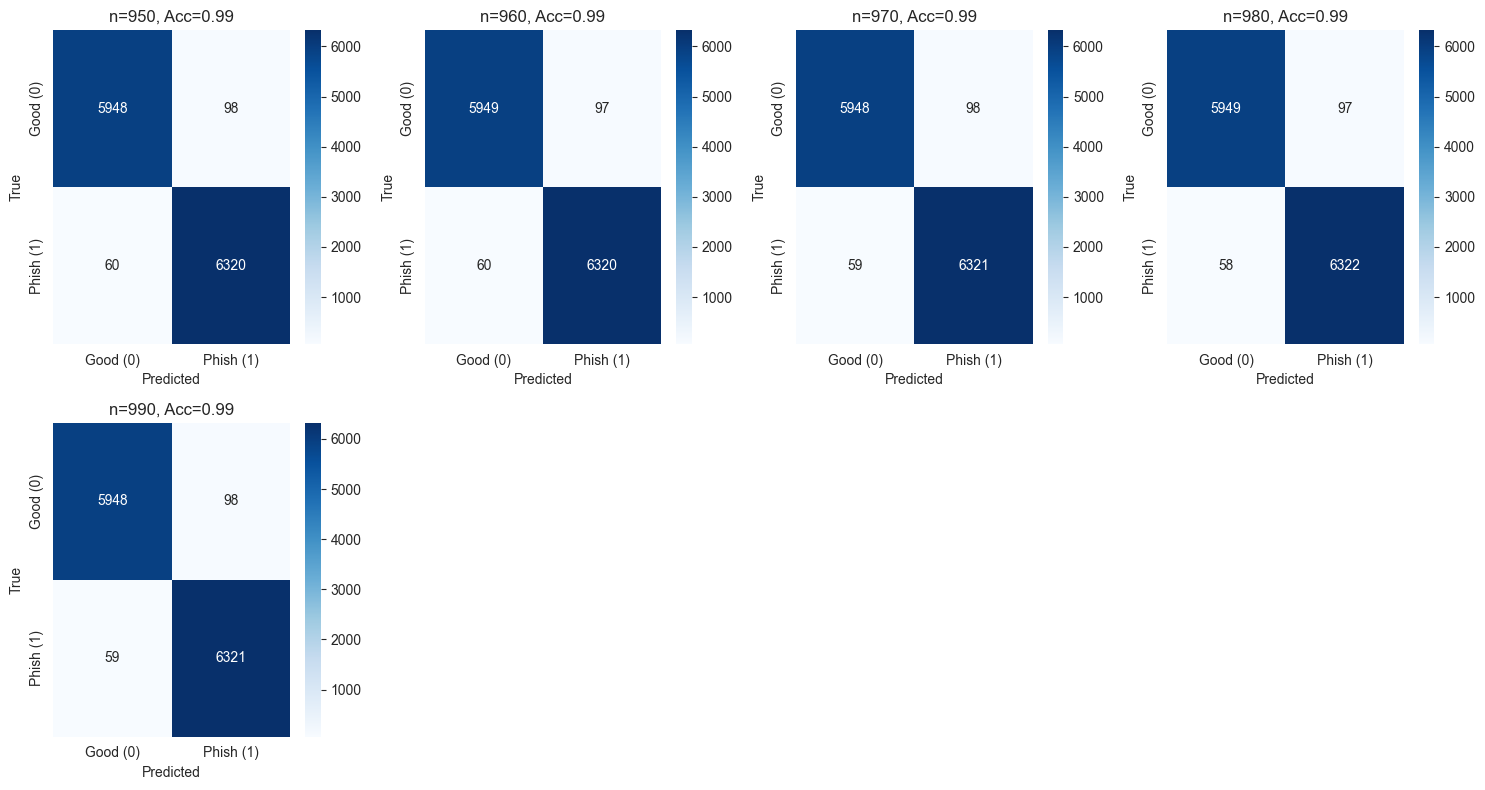

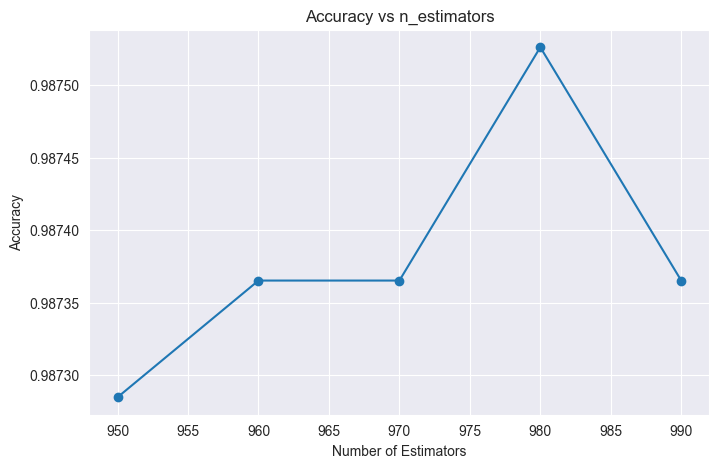

In [8]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from xgboost import XGBClassifier
from joblib import Parallel, delayed

# Load dataset
df_1 = pd.read_csv(r"C:\Users\may\Desktop\dataset\CEAS_08.csv")
df_2 = pd.read_csv(r"C:\Users\may\Desktop\dataset\data.csv")
df_3 = pd.read_csv(r"C:\Users\may\Desktop\dataset\balanced.csv")

# Extract relevant features and target
df_1 = df_1[['sender', 'subject', 'body', 'label']]
df_2 = df_2.rename(columns={'Email Text': 'body', 'Email Type': 'label'})
df_3 = df_3.rename(columns={'class': 'label'})

# Convert Email Type to boolean
df_2['label'] = df_2['label'].map({'Safe Email': 0, 'Phishing Email': 1})

# Remove empty values
df_1 = df_1.dropna(subset=['body', 'subject', 'label'])
df_2 = df_2.dropna(subset=['body'])
df_3 = df_3.dropna(subset=['body', 'label'])

# Add missing columns
df_2['sender'] = ''
df_2['subject'] = ''
df_3['sender'] = ''
df_3['subject'] = ''

# Combine datasets
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
df = df[df['label'].isin([0, 1])]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text Cleaning Function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply text cleaning
df['cleaned_sender'] = df['sender'].apply(clean_text)
df['cleaned_subject'] = df['subject'].apply(clean_text)
df['cleaned_body'] = df['body'].apply(clean_text)

# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Define range for n_estimators (10 to 1000, step size 50)
n_estimators_list = range(950, 1000, 10)

# Function to train a model and return results
def train_model(n, X_train, X_test, y_train, y_test):
    xgb_model = XGBClassifier(n_estimators=n, use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    return n, accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred)

# Run training in parallel
results = Parallel(n_jobs=-1)(delayed(train_model)(n, X_train, X_test, y_train, y_test)
                              for n in n_estimators_list)

# Unpack results into dictionaries
accuracies = {n: acc for n, acc, _ in results}
confusion_matrices = {n: cm for n, _, cm in results}

# Print accuracies
for n in n_estimators_list:
    print(f"n_estimators={n}, Accuracy={accuracies[n]:.4f}")

# Plot Confusion Matrices
n_plots = len(n_estimators_list)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for idx, (n, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Good (0)', 'Phish (1)'],
                yticklabels=['Good (0)', 'Phish (1)'],
                ax=axes[idx])
    axes[idx].set_title(f"n={n}, Acc={accuracies[n]:.2f}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("True")

# Hide unused subplots
for i in range(n_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Plot accuracy vs n_estimators
plt.figure(figsize=(8, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o')
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs n_estimators")
plt.grid(True)
plt.show()